# I. Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from graphviz import Source

# II. Preparing the datasets

In [2]:
# Cấu hình đường dẫn và tham số
class Config:
    train_size = 0.8
    data_path = r'..\Penguins\penguins_size.csv'
    save_dir = r'.\.Penguins\plots'
    
cfg = Config()

In [3]:
# Đọc và hiển thị thông tin dataset
df = pd.read_csv(cfg.data_path)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None


species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE

In [4]:
# Loại bỏ những dòng chứa Nan
df = df.dropna()
labels = df['species']

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB
None


species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
4  Adelie  Torgersen              36.7             19.3              193.0   
5  Adelie  Torgersen              39.3             20.6              190.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
4       3450.0  FEMALE  
5       3650.0    MALE

Từ 344 data samples thành 334 samples

# III. Data Analysis Functions

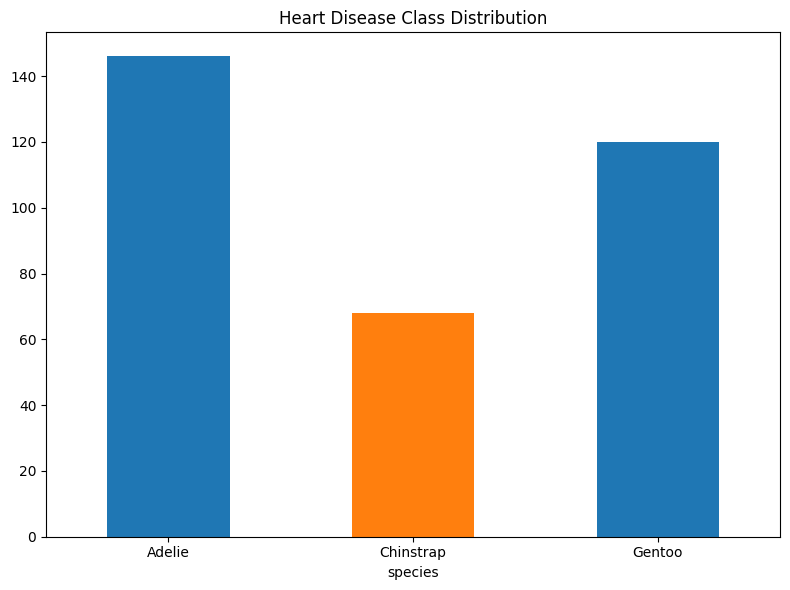

In [5]:
# Hàm vẽ biểu đồ phân phối lớp
def plot_class_distribution(labels, title="Heart Disease Class Distribution"):
    class_counts = labels.value_counts().sort_index()
    
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
    plt.title(title)
    plt.xticks(range(len(class_counts)), rotation=0)
    plt.tight_layout()
    
    plt.show()
    
plot_class_distribution(labels)

In [6]:
# Hàm chia và chuẩn hóa dữ liệu
def split_and_scale_data(X, y, proportions):
    X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=X.index)
    
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    X_shuffled = X_scaled.iloc[indices]
    y_shuffled = y.iloc[indices]
    
    subsets = [
        {
            'train_size': p,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }
        for p in proportions
        for X_train, X_test, y_train, y_test in [train_test_split(
            X_shuffled, y_shuffled,
            train_size=p,
            stratify=y_shuffled,
            random_state=42
        )]
    ]
    
    return subsets, X_scaled

# IV. Split Dataset into Different Ratios

In [7]:
# Chuẩn bị dữ liệu cho thực nghiệm
le = LabelEncoder()

X = df.drop(columns=['species'])
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column])
    
    
y = labels

proportions = [0.4, 0.6, 0.8, 0.9]

subset_data, X = split_and_scale_data(X, y, proportions)


## 1. Display the class distribution of subsets

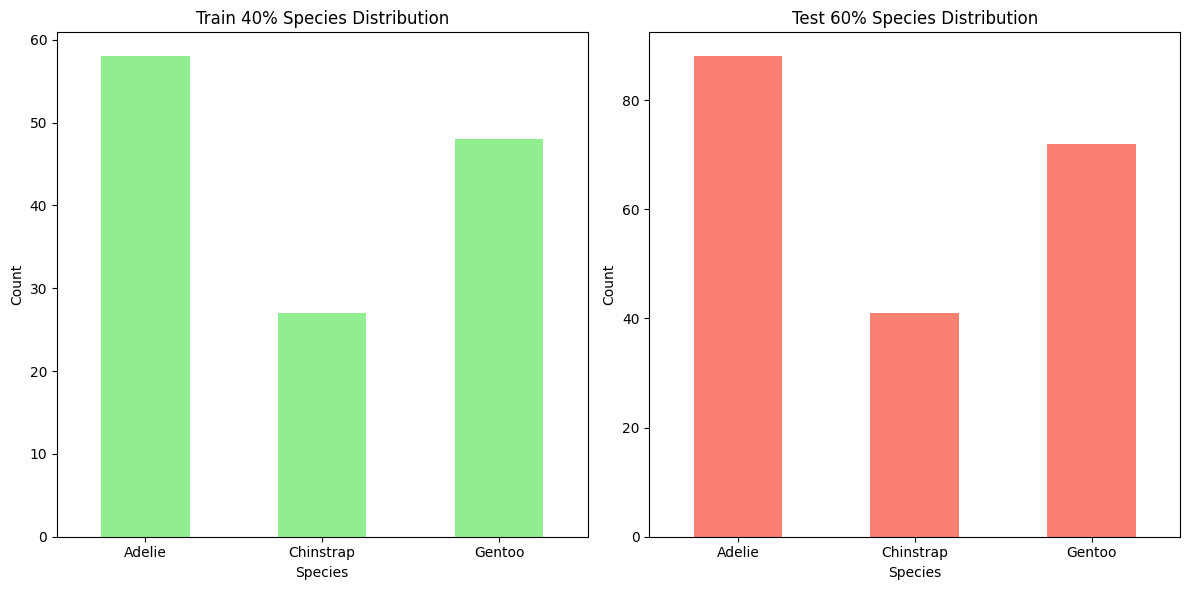

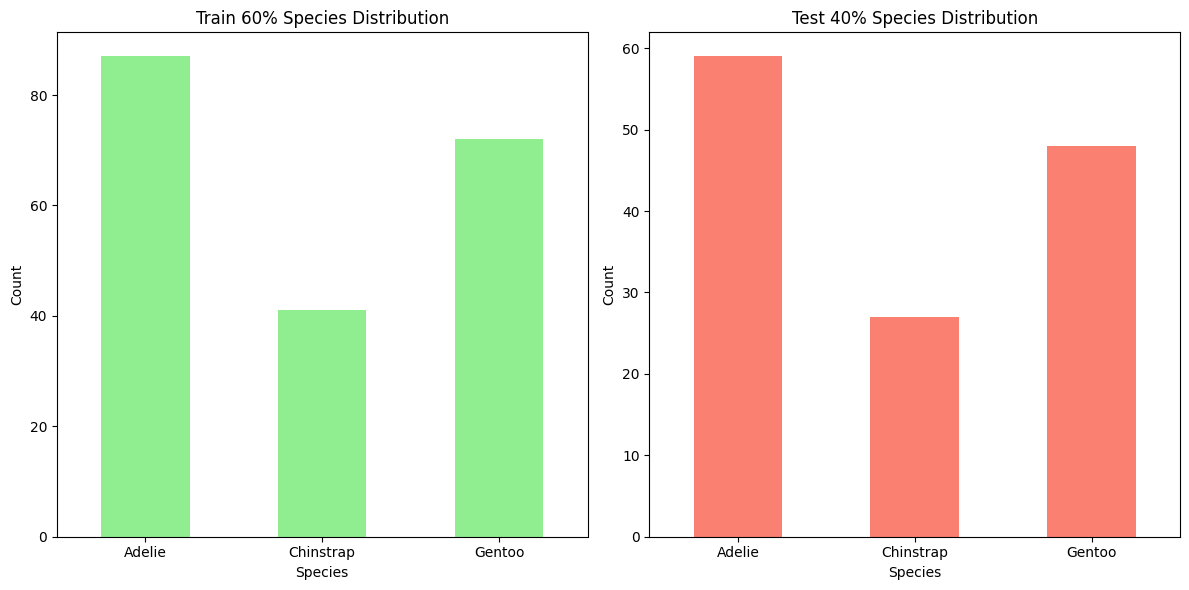

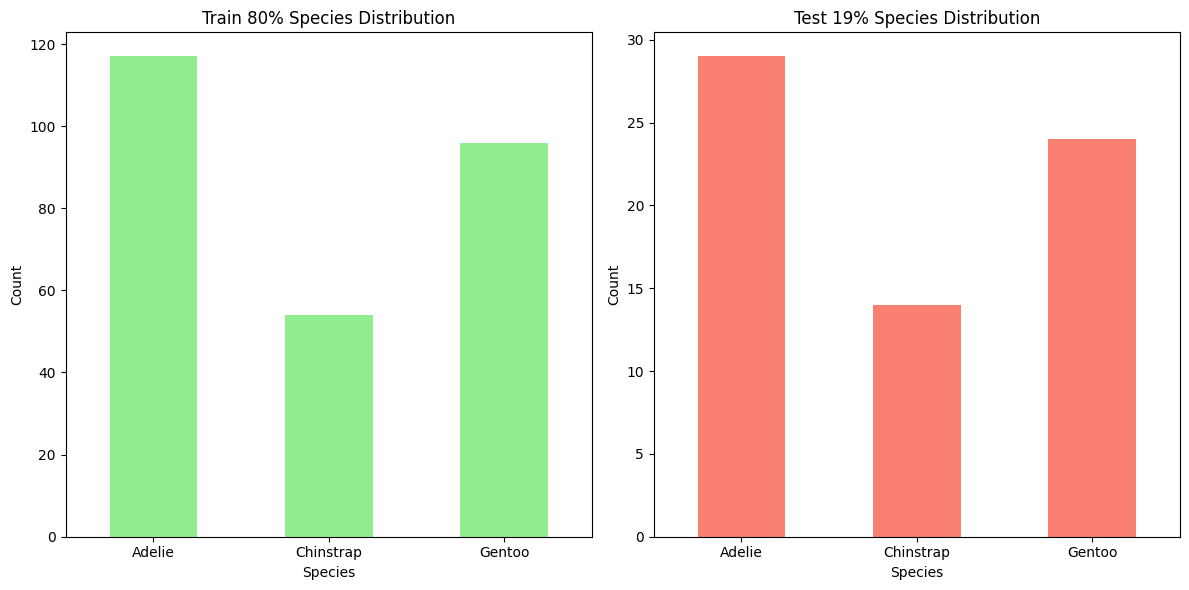

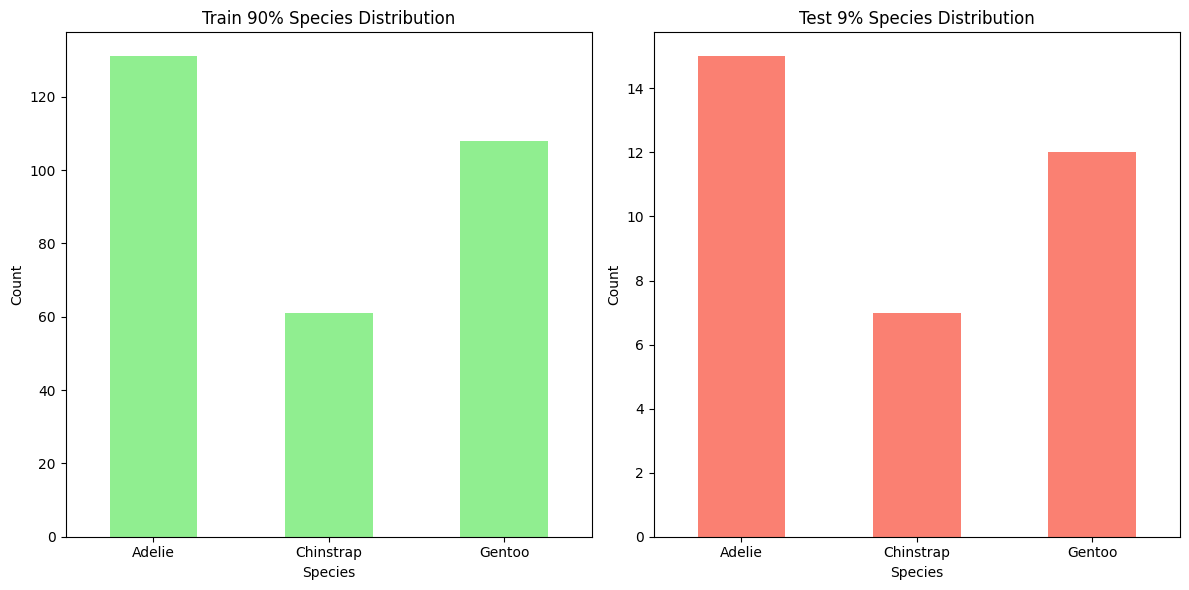

In [8]:
# Hàm vẽ phân phối lớp trong tập train/test
def plot_subset_class_distribution(subsets):
    for subset in subsets:
        train_size = subset['train_size']
        y_train = subset['y_train']
        y_test = subset['y_test']
        
        plt.figure(figsize=(12, 6))
        
        # Plot train class distribution
        train_class_dist = pd.Series(y_train).value_counts().sort_index()
        plt.subplot(1, 2, 1)
        train_class_dist.plot(kind='bar', color='lightgreen')
        plt.title(f"Train {int(train_size*100)}% Species Distribution")
        plt.xlabel("Species")
        plt.ylabel("Count")
        plt.xticks(ticks=range(len(train_class_dist)), labels=train_class_dist.index, rotation=0)
        
        # Plot test class distribution
        test_class_dist = pd.Series(y_test).value_counts().sort_index()
        plt.subplot(1, 2, 2)
        test_class_dist.plot(kind='bar', color='salmon')
        plt.title(f"Test {int((1-train_size)*100)}% Species Distribution")
        plt.xlabel("Species")
        plt.ylabel("Count")
        plt.xticks(ticks=range(len(test_class_dist)), labels=test_class_dist.index, rotation=0)
        
        plt.tight_layout()
        plt.show()

plot_subset_class_distribution(subset_data)


## 2. Experiments

In [9]:
# Hàm vẽ confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=True)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.title('Decision Tree Classifier confusion matrix', fontsize=14)
    plt.tight_layout()
    
    plt.show()

In [10]:
# Hàm trực quan hóa cây quyết định
def visualize_decision_tree(max_depth, feature_names, class_names, model, data):
    dot_data = export_graphviz(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    graph = Source(dot_data)
    filename = f"tree_depth_{max_depth}_train_{int(data['train_size'] * 100)}"
    graph.render(filename, format="png", cleanup=True)
    
    img_path = f"{filename}.png"
    display(Image(filename=img_path))
    print(f"Saved decision tree as {img_path}")


=== Experiment with Train Size: 40% ===
=== Visualizing Decision Tree (max_depth=3) ===


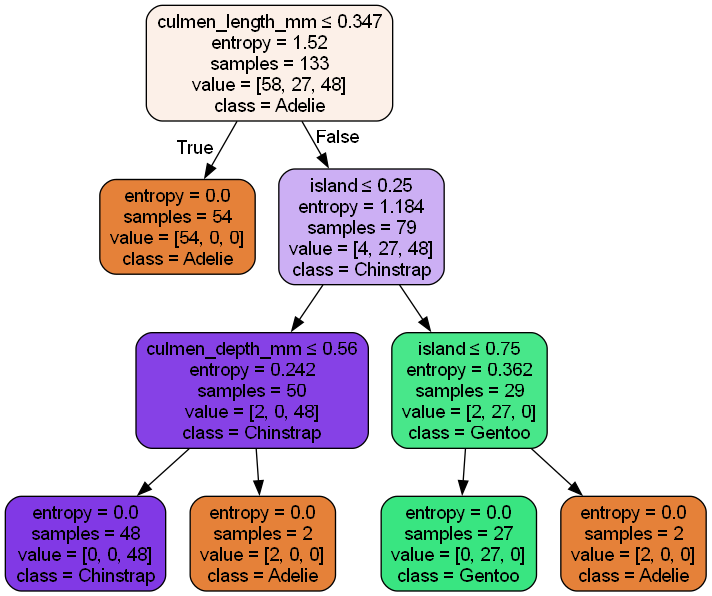

Saved decision tree as tree_depth_3_train_40.png
=== Classification Report ===
              precision    recall  f1-score   support

      Adelie       0.98      0.95      0.97        88
      Gentoo       0.91      0.98      0.94        41
   Chinstrap       1.00      0.99      0.99        72

    accuracy                           0.97       201
   macro avg       0.96      0.97      0.97       201
weighted avg       0.97      0.97      0.97       201

=== Confusion Matrix (saved as confusion_matrix_train_size_40.png) ===


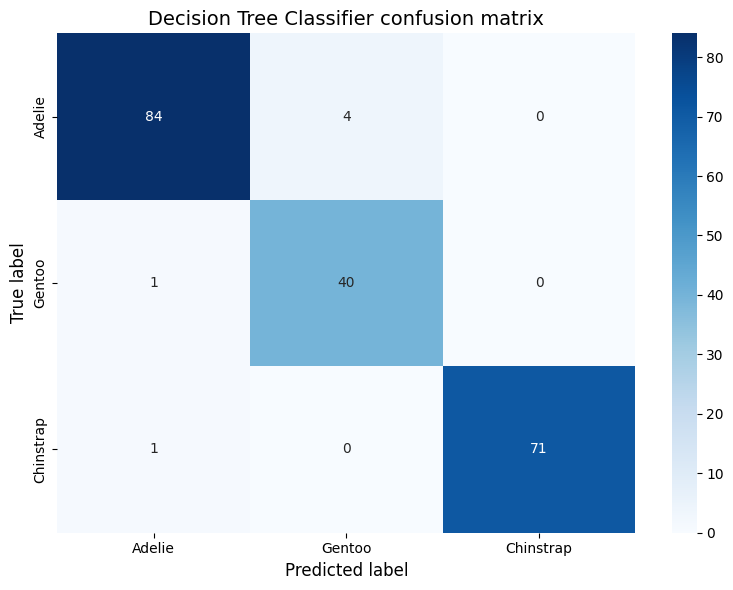

=== Visualizing Decision Tree (max_depth=4) ===


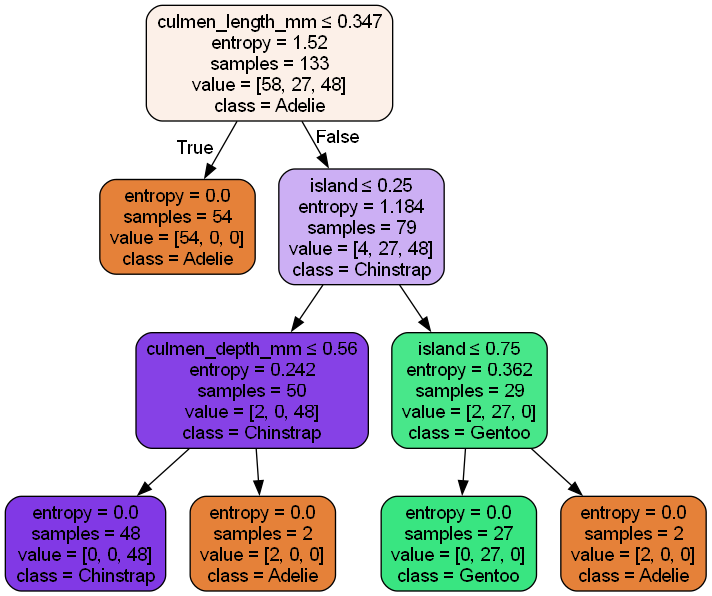

Saved decision tree as tree_depth_4_train_40.png

=== Experiment with Train Size: 60% ===
=== Visualizing Decision Tree (max_depth=3) ===


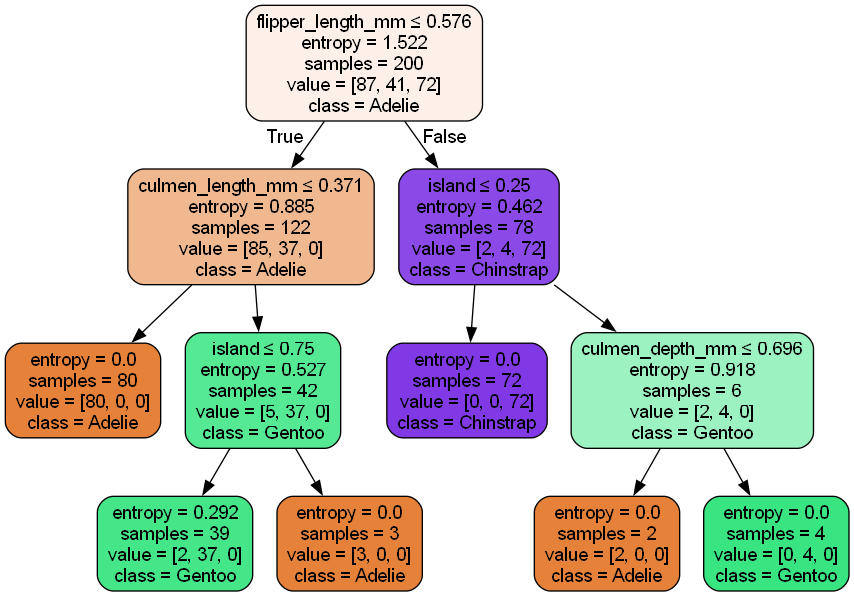

Saved decision tree as tree_depth_3_train_60.png
=== Classification Report ===
              precision    recall  f1-score   support

      Adelie       0.98      0.95      0.97        59
      Gentoo       0.87      0.96      0.91        27
   Chinstrap       1.00      0.98      0.99        48

    accuracy                           0.96       134
   macro avg       0.95      0.96      0.96       134
weighted avg       0.97      0.96      0.96       134

=== Confusion Matrix (saved as confusion_matrix_train_size_60.png) ===


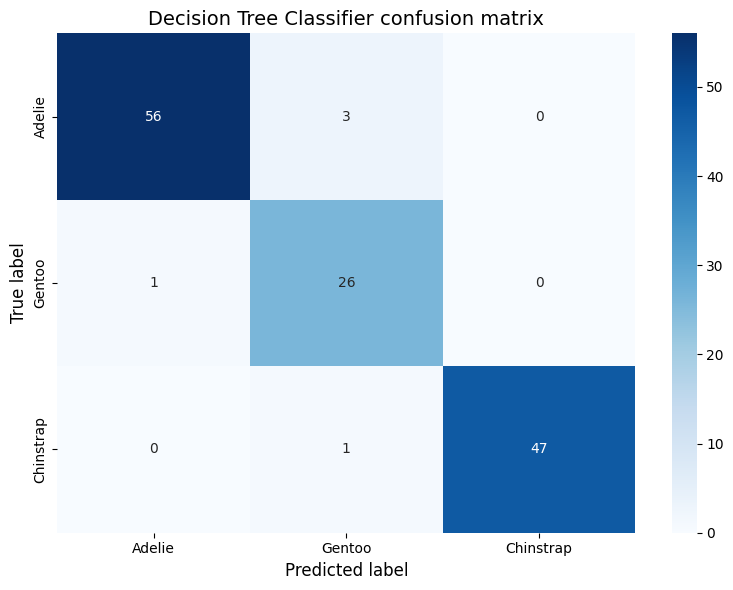

=== Visualizing Decision Tree (max_depth=4) ===


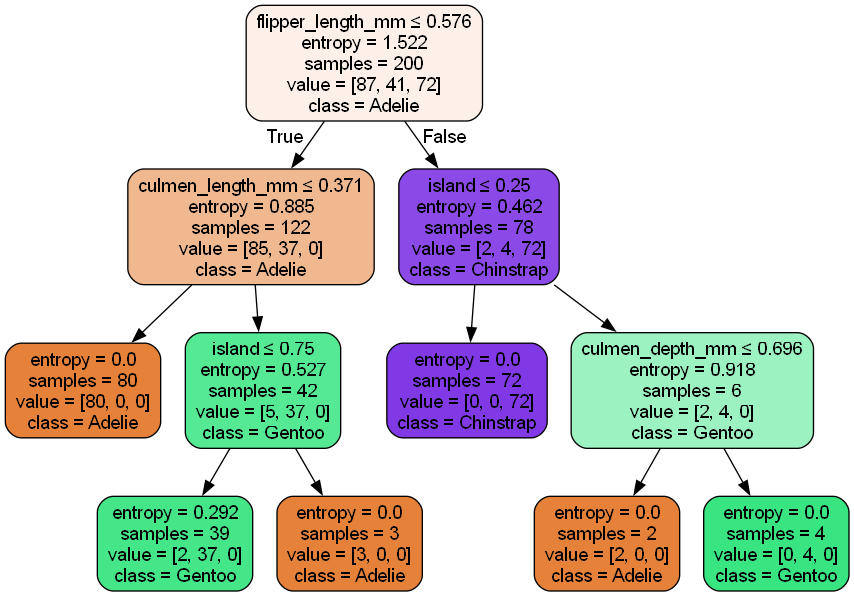

Saved decision tree as tree_depth_4_train_60.png

=== Experiment with Train Size: 80% ===
=== Visualizing Decision Tree (max_depth=3) ===


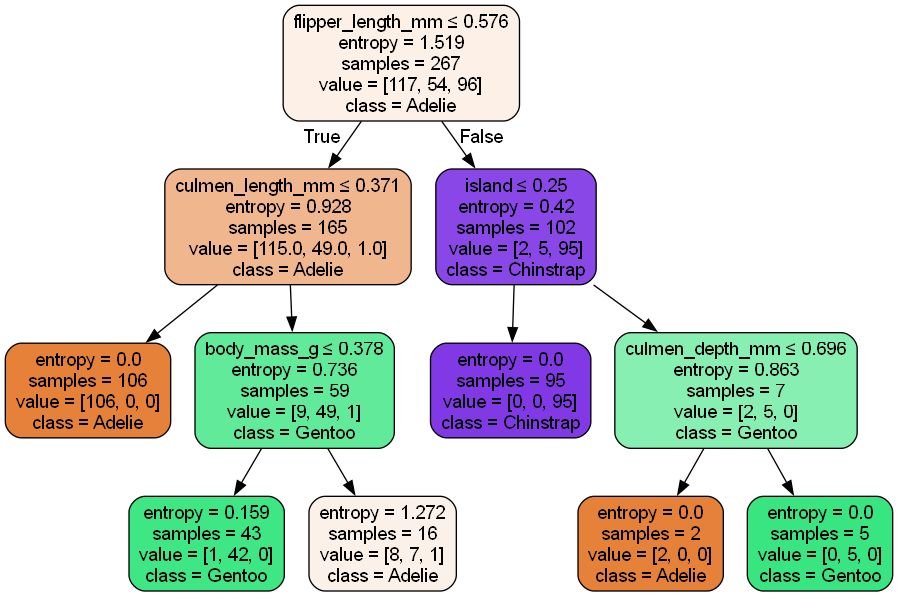

Saved decision tree as tree_depth_3_train_80.png
=== Classification Report ===
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        29
      Gentoo       1.00      0.86      0.92        14
   Chinstrap       1.00      1.00      1.00        24

    accuracy                           0.97        67
   macro avg       0.98      0.95      0.96        67
weighted avg       0.97      0.97      0.97        67

=== Confusion Matrix (saved as confusion_matrix_train_size_80.png) ===


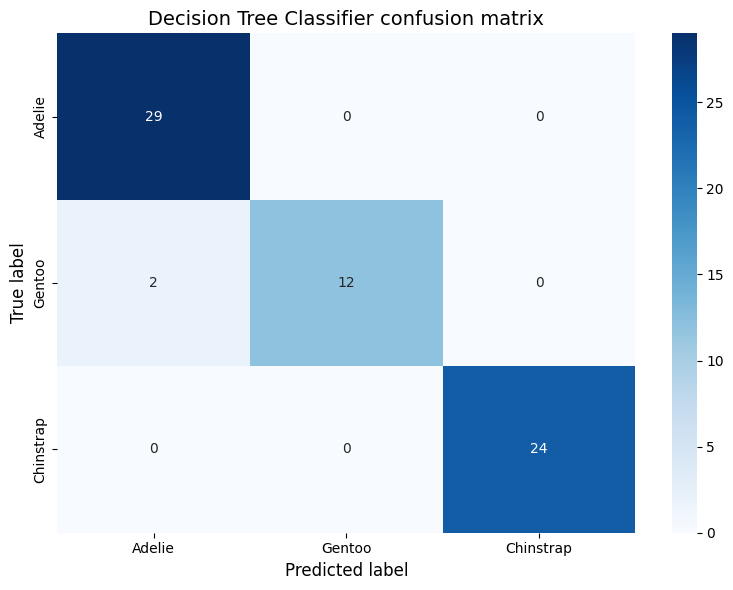

=== Visualizing Decision Tree (max_depth=4) ===


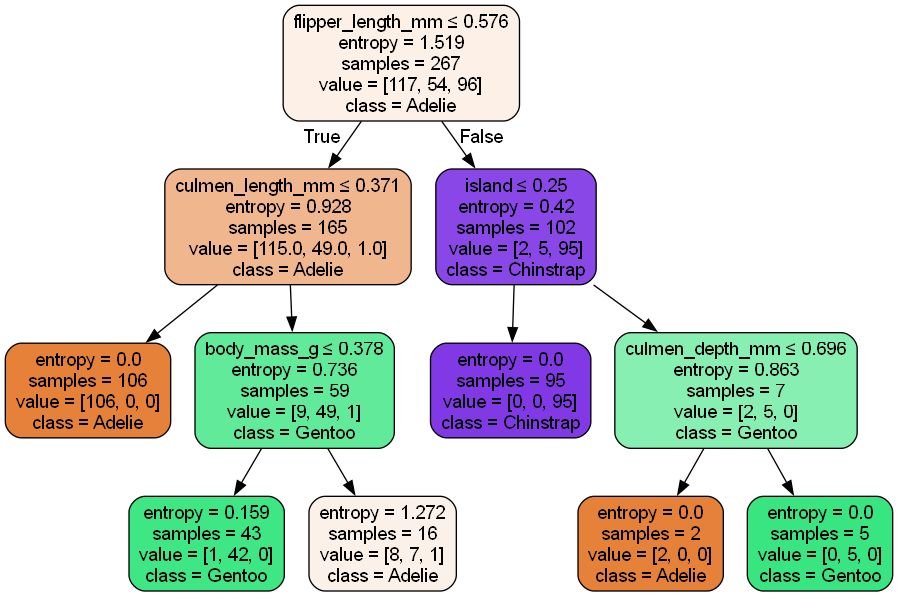

Saved decision tree as tree_depth_4_train_80.png

=== Experiment with Train Size: 90% ===
=== Visualizing Decision Tree (max_depth=3) ===


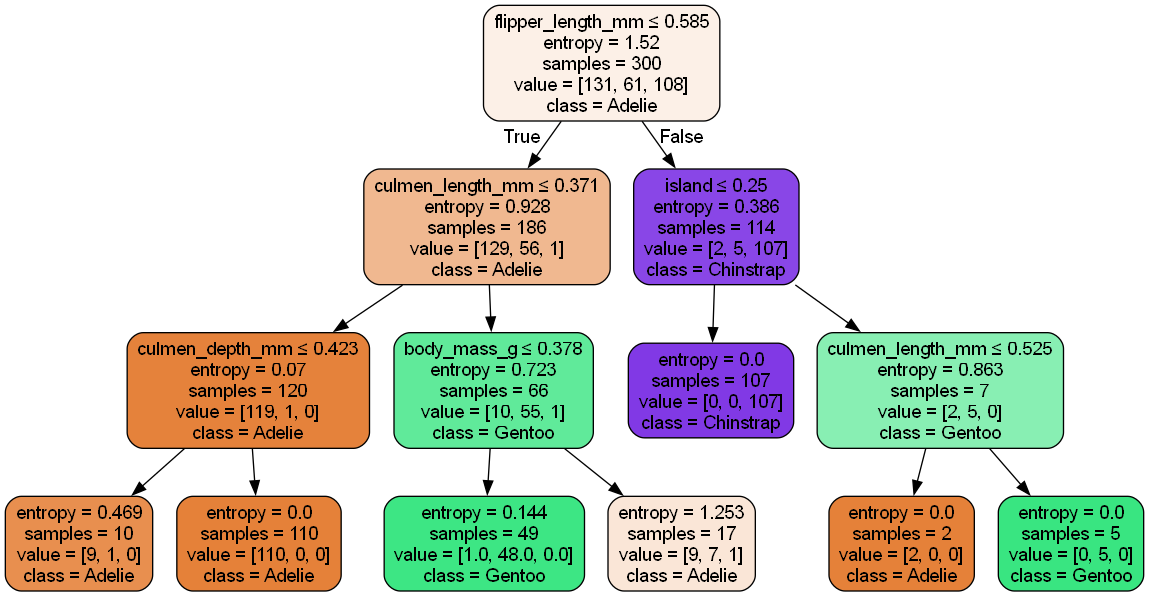

Saved decision tree as tree_depth_3_train_90.png
=== Classification Report ===
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        15
      Gentoo       1.00      0.86      0.92         7
   Chinstrap       1.00      1.00      1.00        12

    accuracy                           0.97        34
   macro avg       0.98      0.95      0.96        34
weighted avg       0.97      0.97      0.97        34

=== Confusion Matrix (saved as confusion_matrix_train_size_90.png) ===


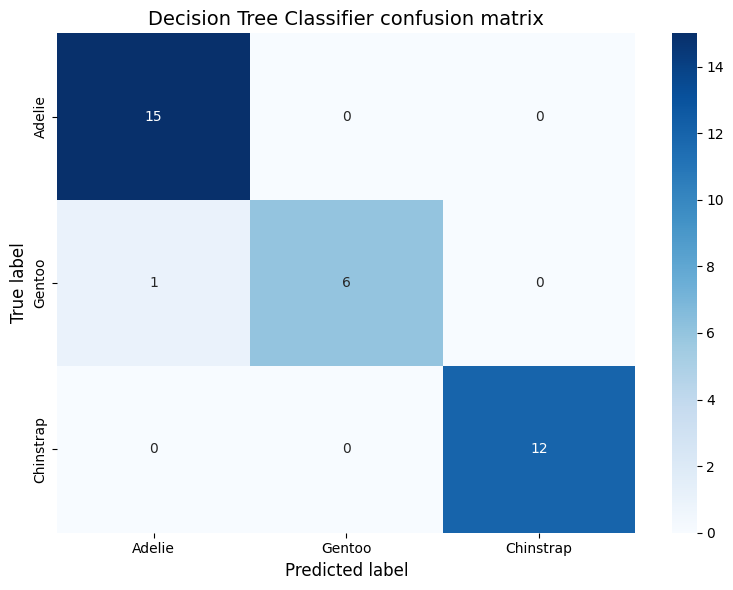

=== Visualizing Decision Tree (max_depth=4) ===


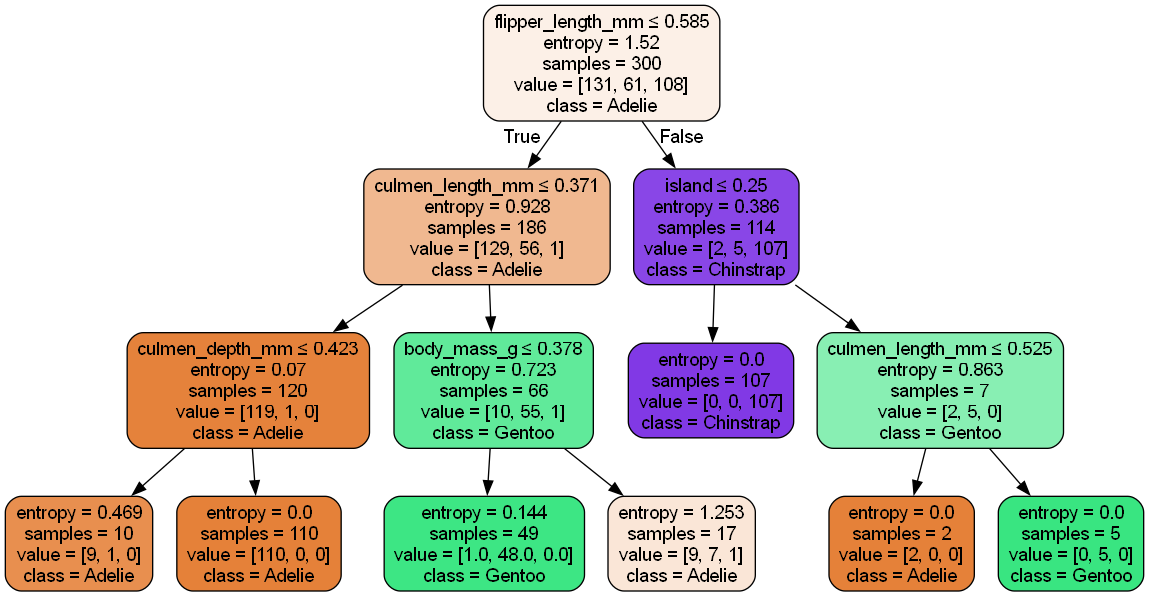

Saved decision tree as tree_depth_4_train_90.png


In [11]:
for data in subset_data:
    print(f"\n=== Experiment with Train Size: {int(data['train_size'] * 100)}% ===")
    
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
    model.fit(data['X_train'], data['y_train'])

    # Hiển thị cây quyết định (max_depth=3)
    print("=== Visualizing Decision Tree (max_depth=3) ===")
    visualize_decision_tree(
        max_depth=3, 
        feature_names=data['X_train'].columns, 
        class_names=['Adelie', 'Gentoo', 'Chinstrap'],  
        model=model,
        data=data
    )
    
    # Đánh giá mô hình
    y_pred = model.predict(data['X_test'])
    print("=== Classification Report ===")
    report = classification_report(data['y_test'], y_pred, target_names=['Adelie', 'Gentoo', 'Chinstrap'])
    print(report)
        
    # Confusion matrix
    cm = confusion_matrix(data['y_test'], y_pred)
    filename = f'confusion_matrix_train_size_{int(data["train_size"] * 100)}.png'
    print(f"=== Confusion Matrix (saved as {filename}) ===")
    plot_confusion_matrix(cm, classes=['Adelie', 'Gentoo', 'Chinstrap'])

    # Hiển thị cây quyết định (max_depth=4)
    print("=== Visualizing Decision Tree (max_depth=4) ===")
    visualize_decision_tree(
        max_depth=4, 
        feature_names=data['X_train'].columns, 
        class_names=['Adelie', 'Gentoo', 'Chinstrap'], 
        model=model,
        data=data
    )

## 3. Evaluate the depth of the decision tree

In [12]:
def evaluate_decision_tree_depths(X, y, max_depths):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    results = []
    
    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        depth_label = 'Unlimited' if depth is None else depth
        
        results.append({'max_depth': depth_label, 'accuracy': accuracy})
        
        visualize_decision_tree(depth, X.columns, ['Adelie', 'Gentoo', 'Chinstrap'], model, {'train_size': 0.8})
        
        plt.figure(figsize=(20, 10))
        plot_tree(model, feature_names=X.columns, class_names=['Adelie', 'Gentoo', 'Chinstrap'], 
                 filled=True, rounded=True)
        plt.title(f'Decision Tree (max_depth = {depth_label})')
        plt.show()
        
        print(f"\nClassification Report for max_depth={depth_label}:")
        print(classification_report(y_test, y_pred, target_names=['Adelie', 'Gentoo', 'Chinstrap']))
        
        cm = confusion_matrix(y_test, y_pred)
        filename = f'confusion_matrix_depth_{depth_label}.png'
        plot_confusion_matrix(cm, classes=['Adelie', 'Gentoo', 'Chinstrap'])
    
    results_df = pd.DataFrame(results)
    
    # Print accuracy summary
    print("\nAccuracy for Different Decision Tree Depths:")
    print(results_df.to_string(index=False))
    
    # Plot accuracy vs max depth
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(results)), results_df['accuracy'], marker='o', color='#1f77b4')
    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(results)), results_df['max_depth'])
    plt.grid(True)
    plt.show()
    
    return results_df

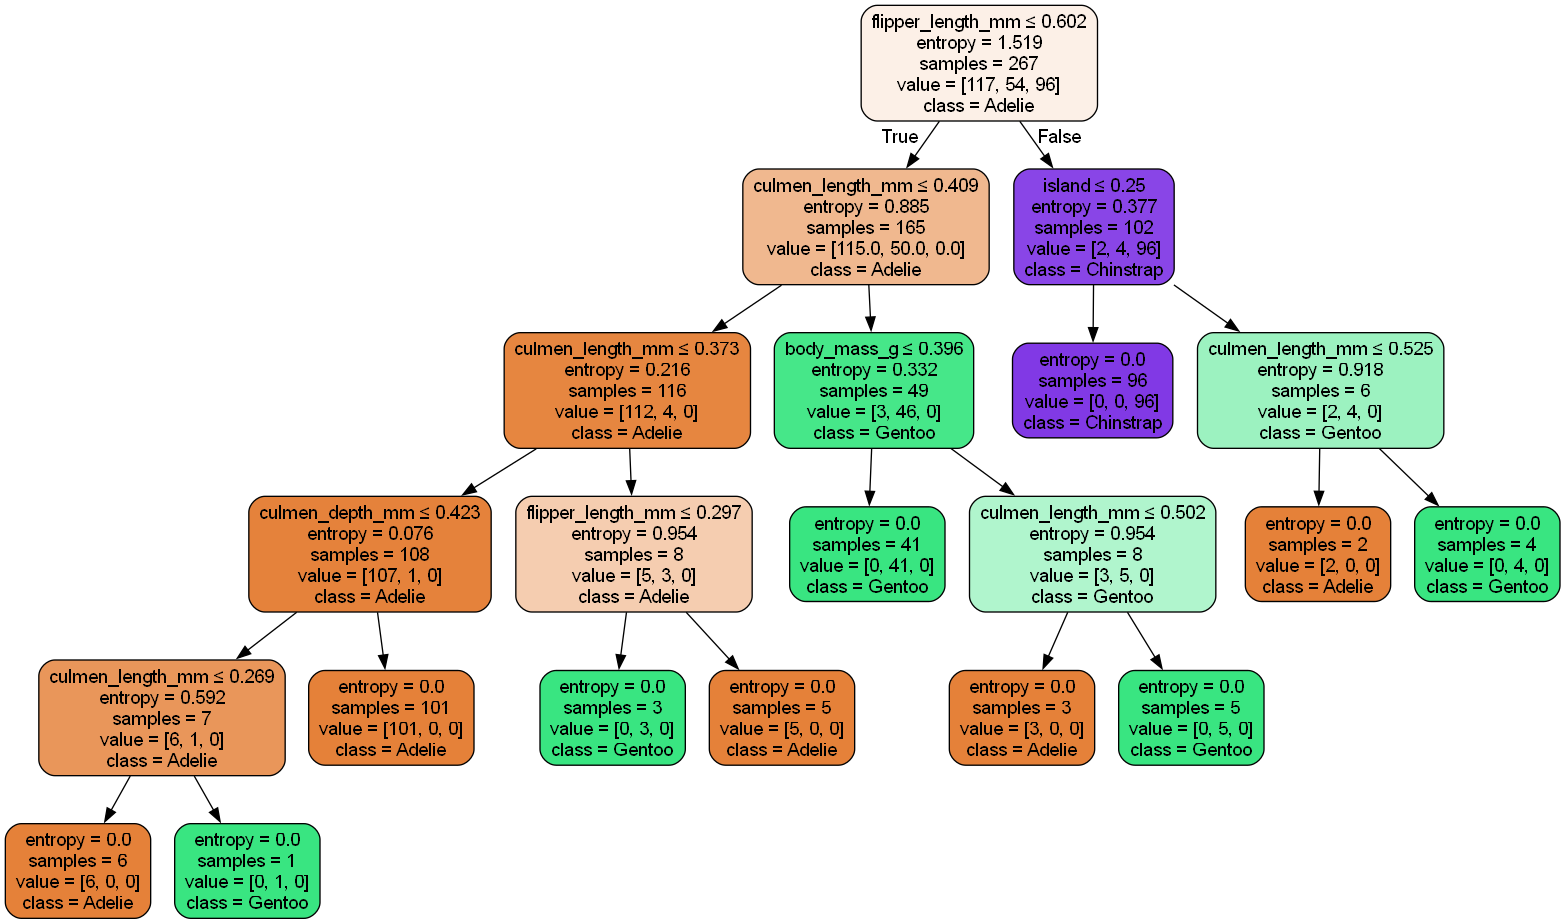

Saved decision tree as tree_depth_None_train_80.png


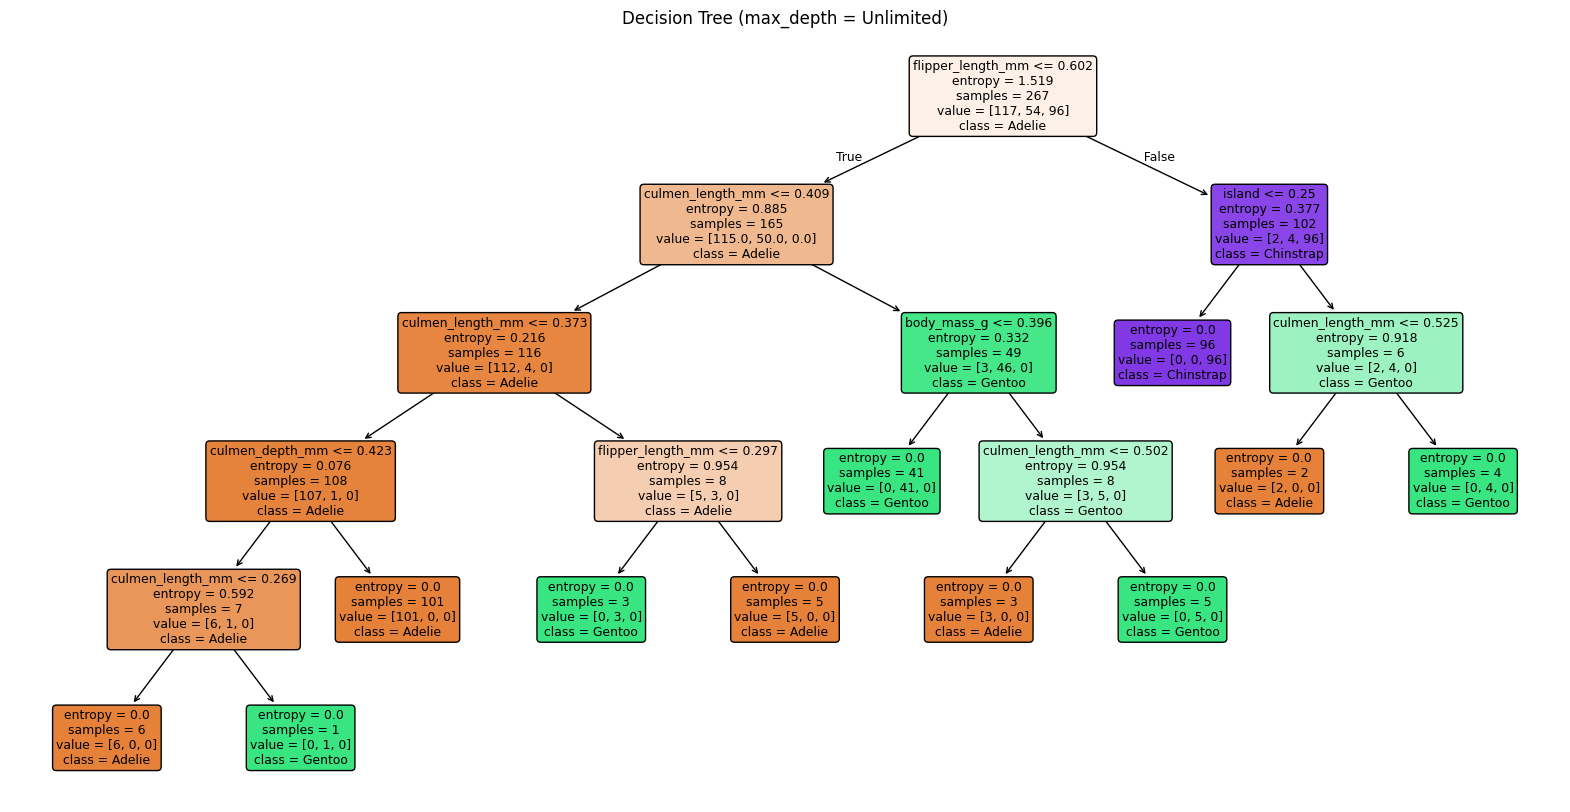


Classification Report for max_depth=Unlimited:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.88      1.00      0.93        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



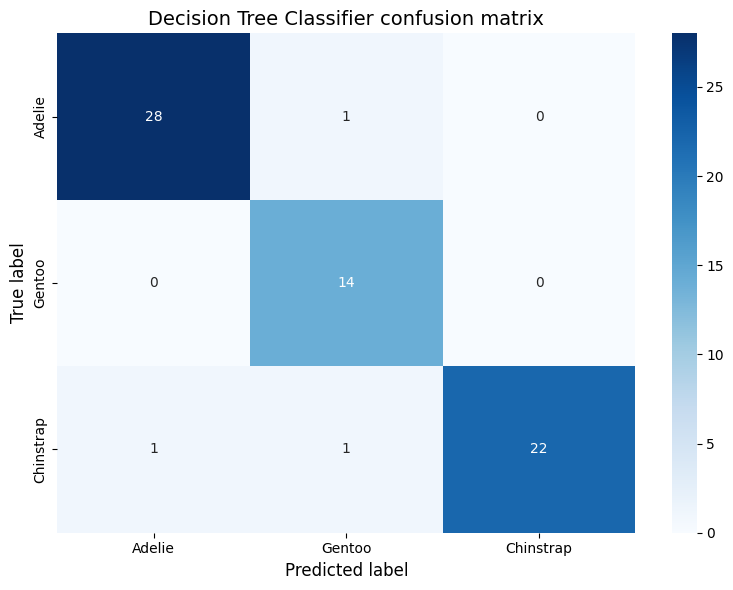

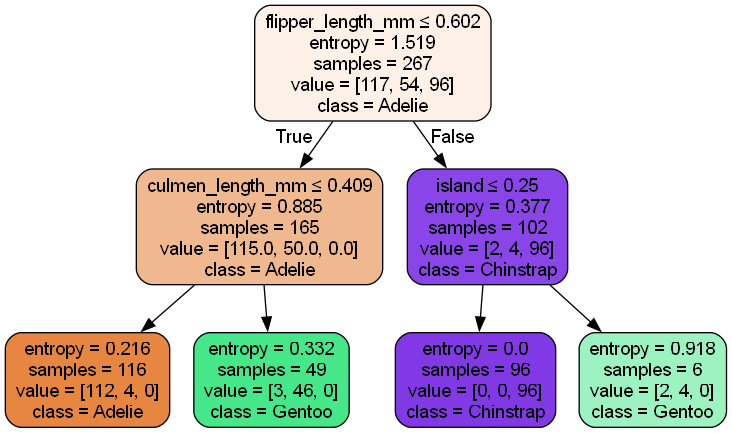

Saved decision tree as tree_depth_2_train_80.png


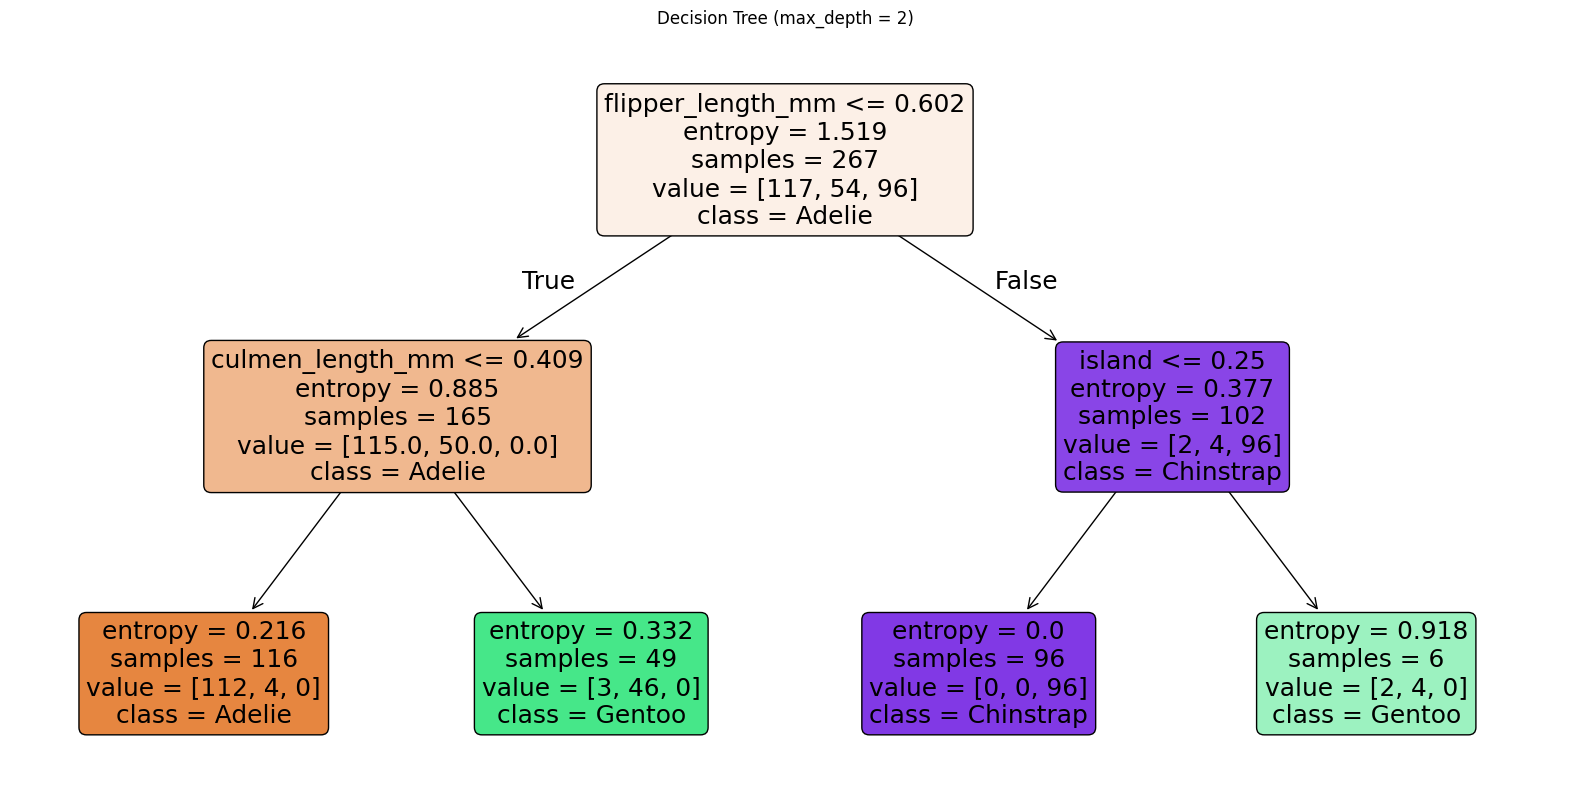


Classification Report for max_depth=2:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.81      0.93      0.87        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.94        67
   macro avg       0.93      0.94      0.93        67
weighted avg       0.95      0.94      0.94        67



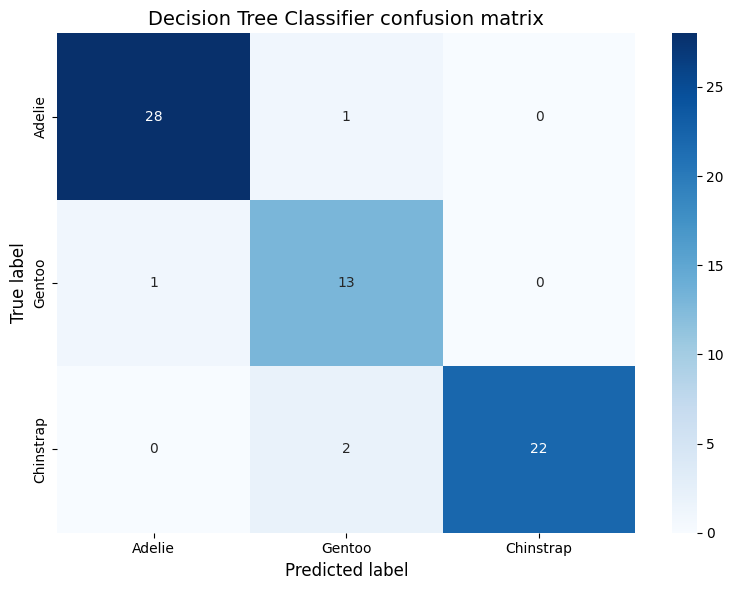

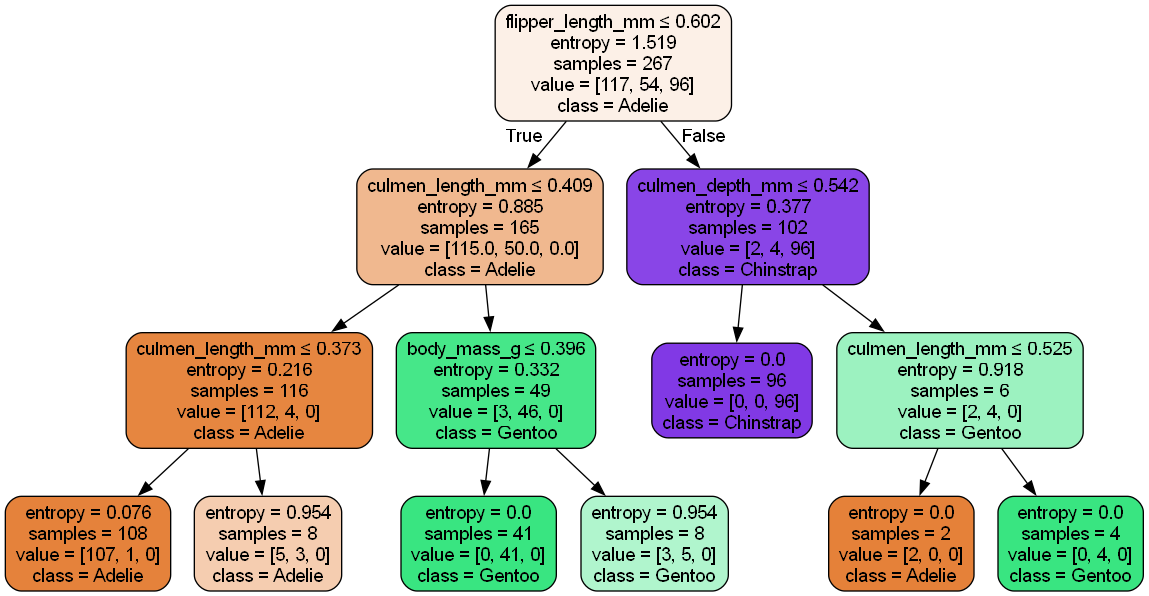

Saved decision tree as tree_depth_3_train_80.png


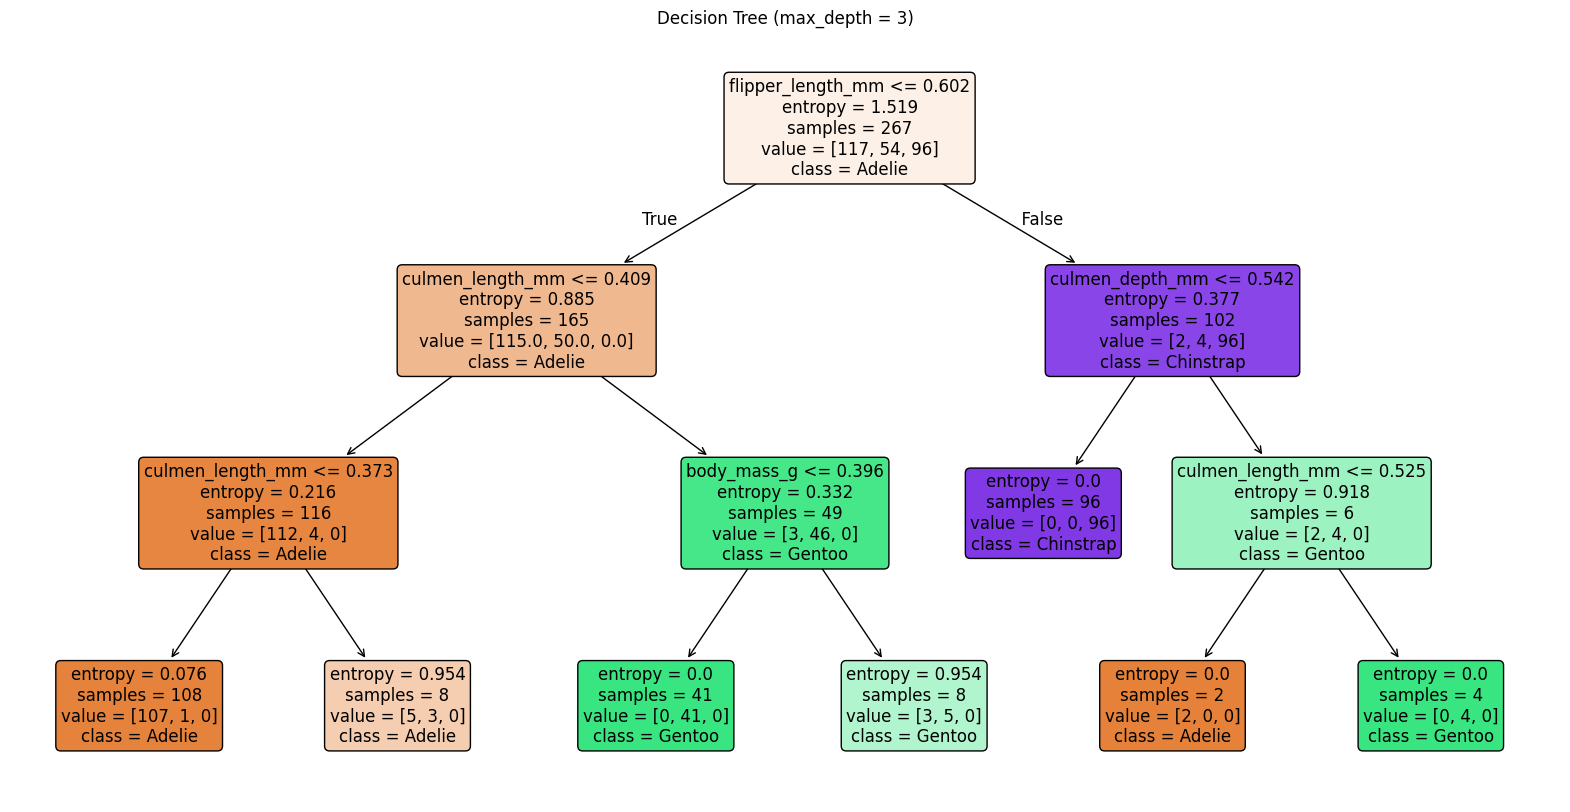


Classification Report for max_depth=3:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.81      0.93      0.87        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.94        67
   macro avg       0.93      0.94      0.93        67
weighted avg       0.95      0.94      0.94        67



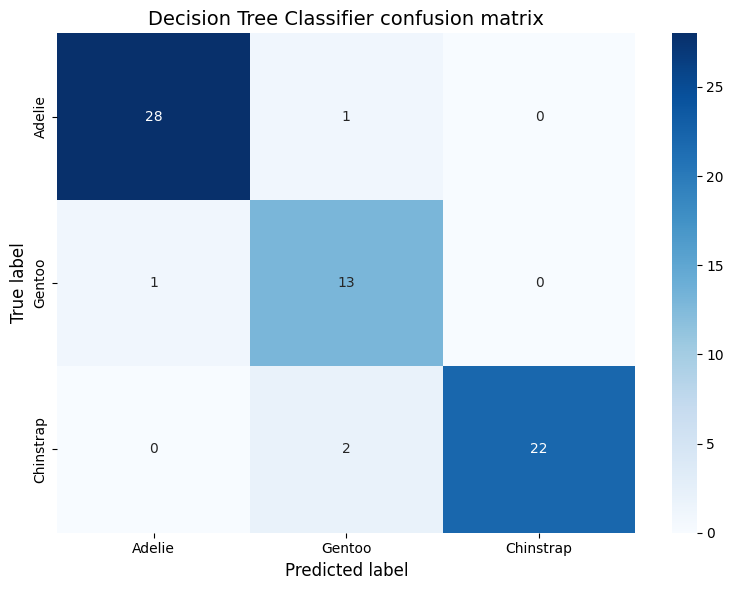

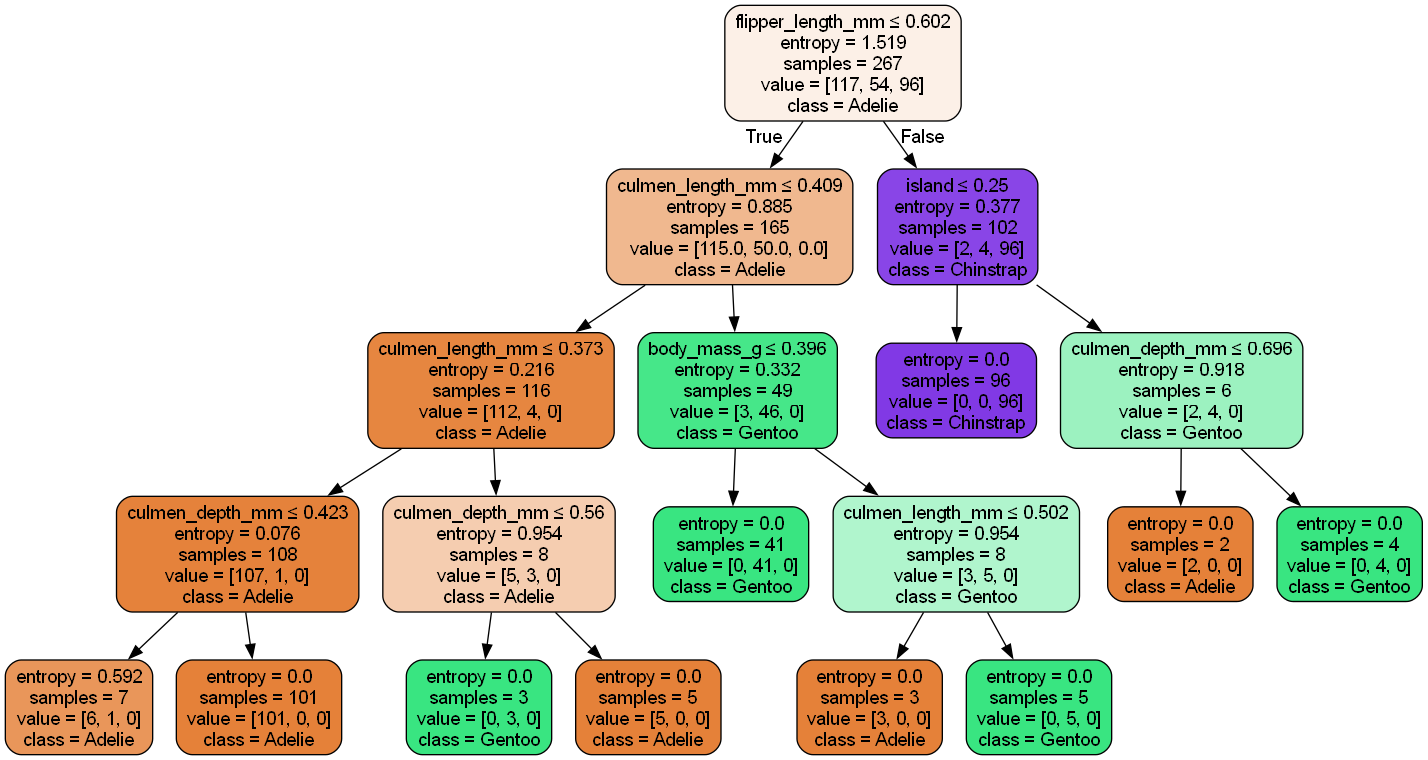

Saved decision tree as tree_depth_4_train_80.png


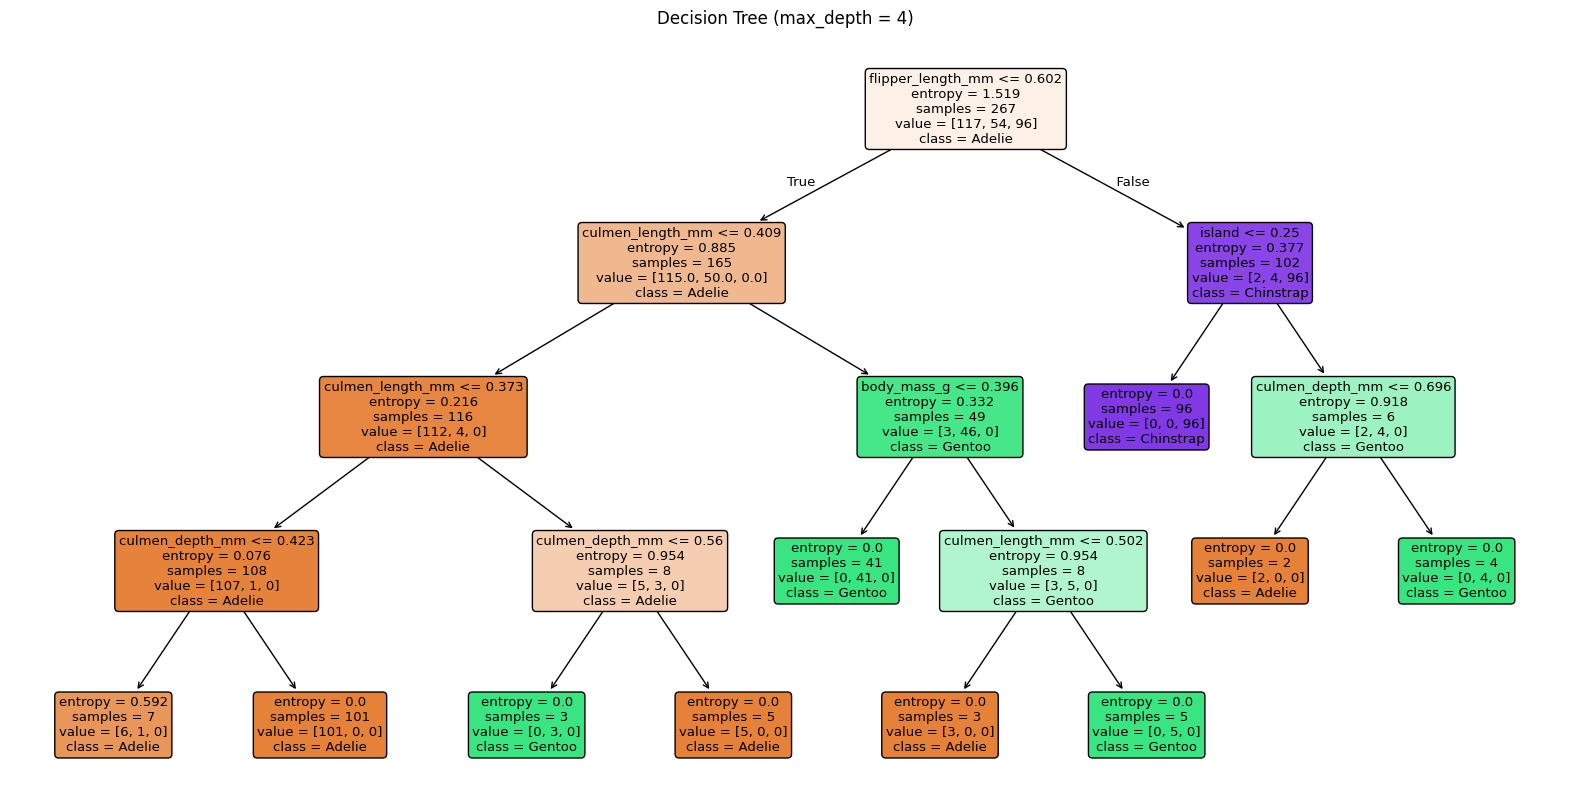


Classification Report for max_depth=4:
              precision    recall  f1-score   support

      Adelie       0.96      0.93      0.95        29
      Gentoo       0.82      1.00      0.90        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.94        67
   macro avg       0.93      0.95      0.94        67
weighted avg       0.95      0.94      0.94        67



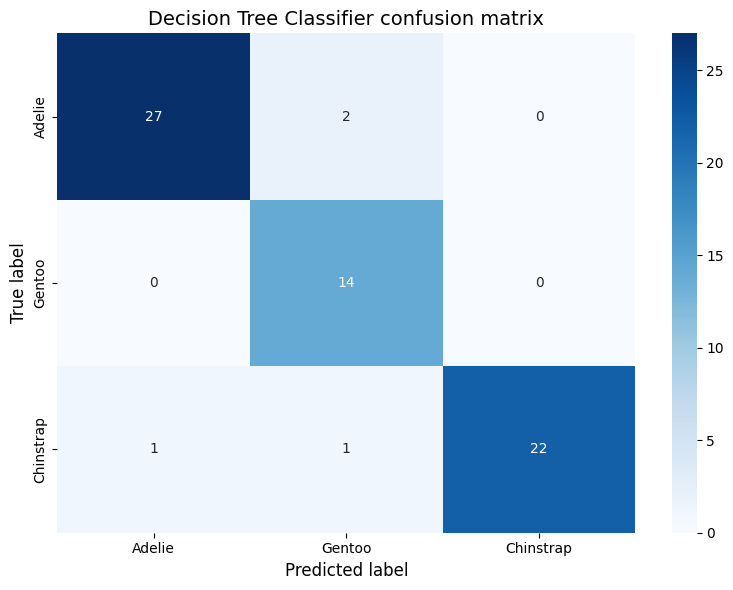

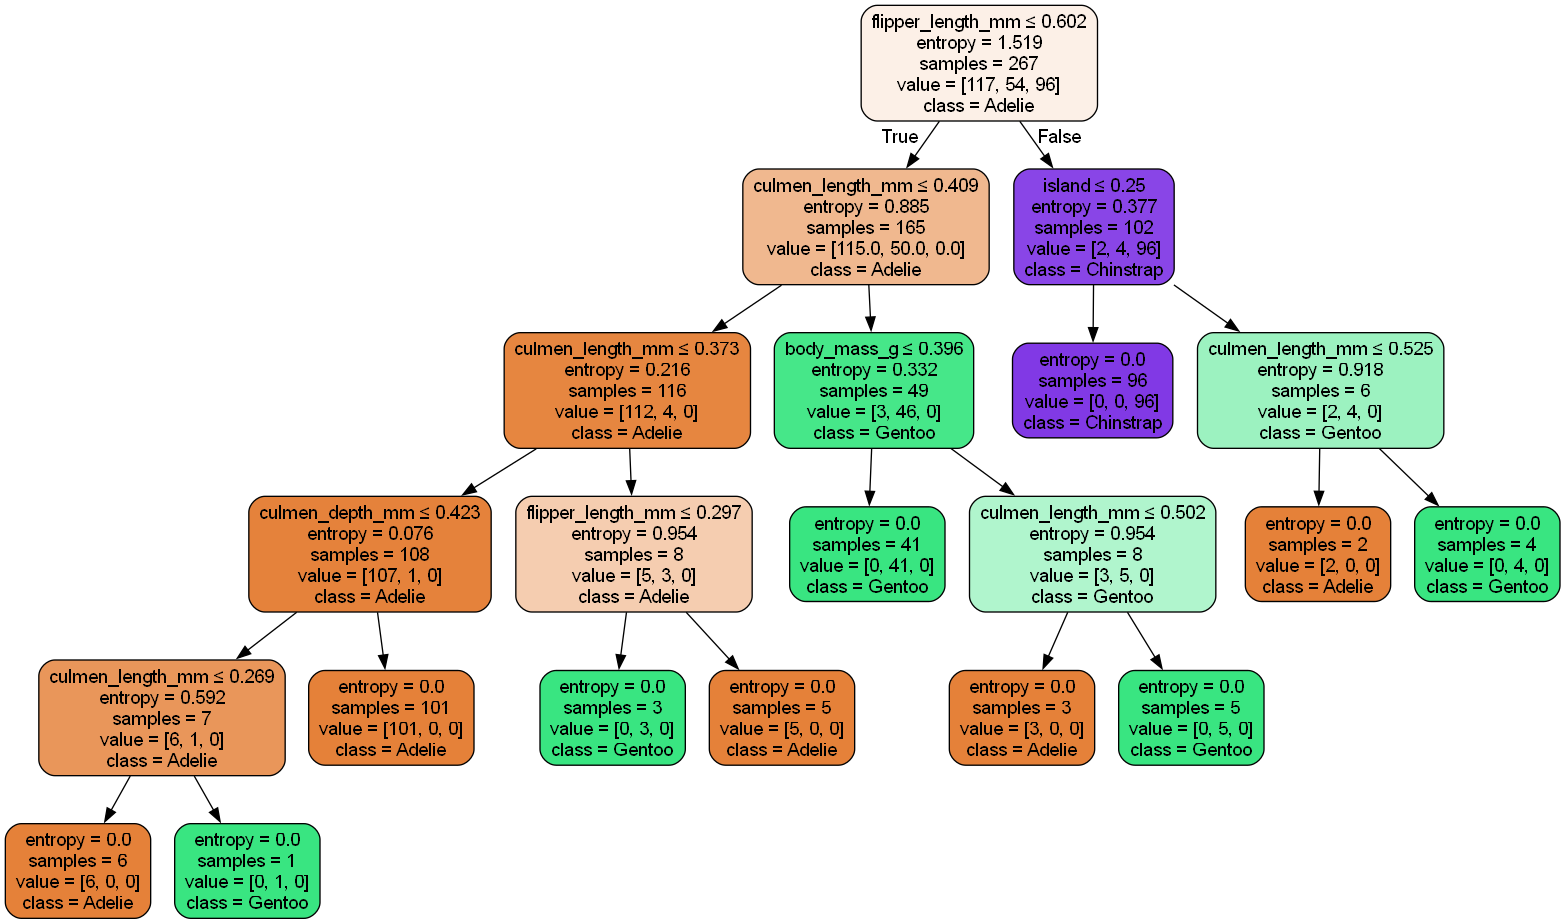

Saved decision tree as tree_depth_5_train_80.png


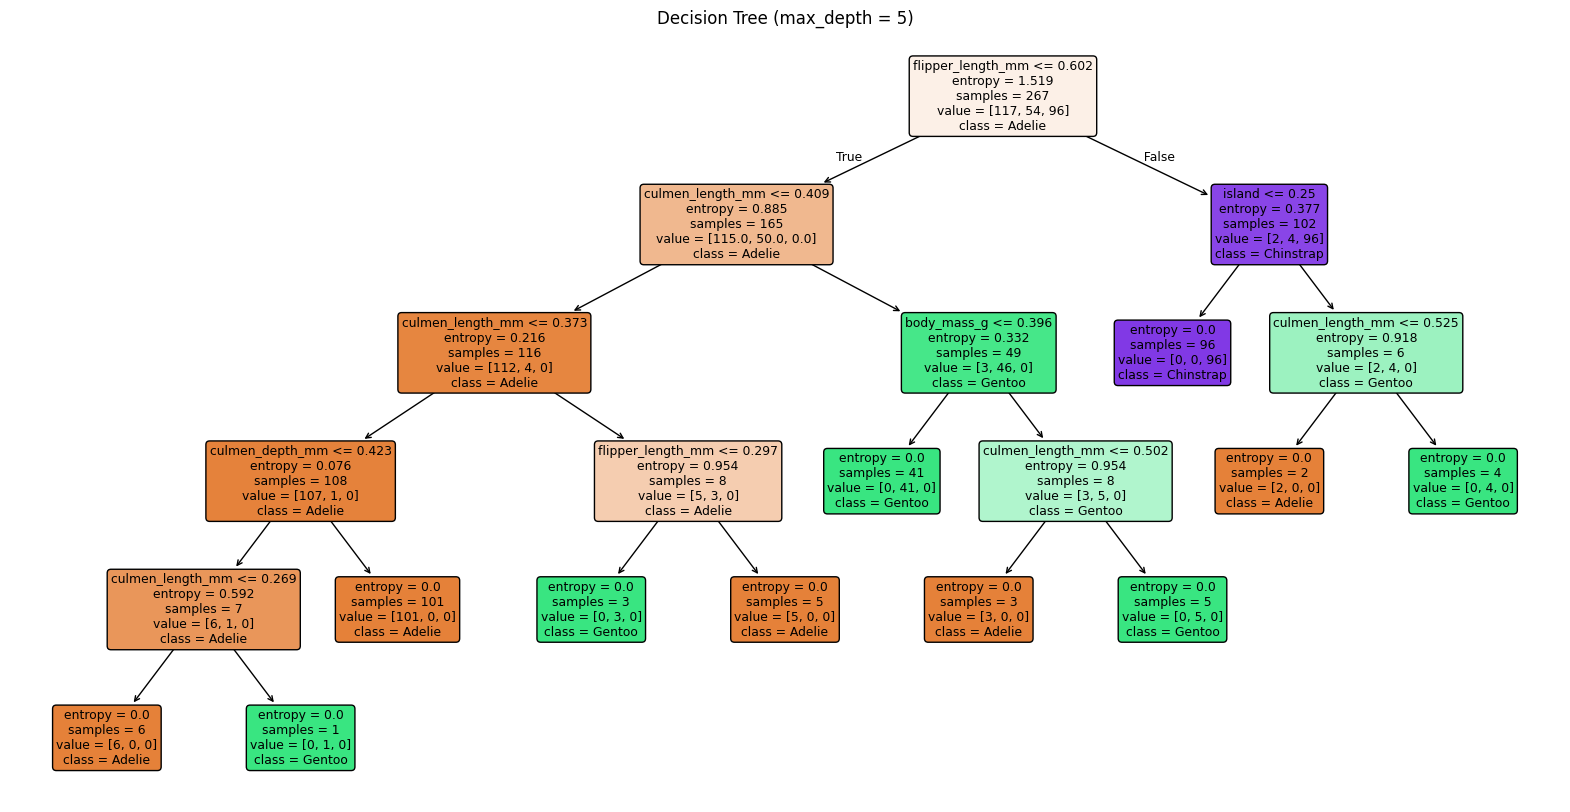


Classification Report for max_depth=5:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.88      1.00      0.93        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



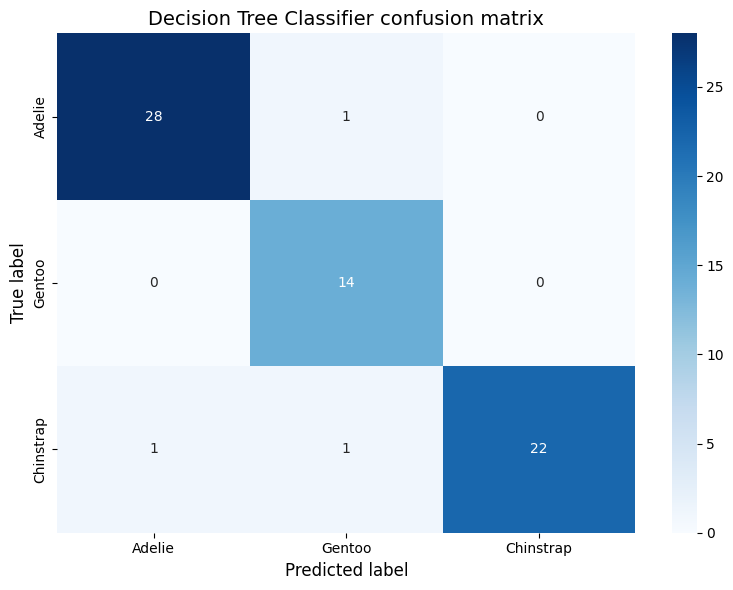

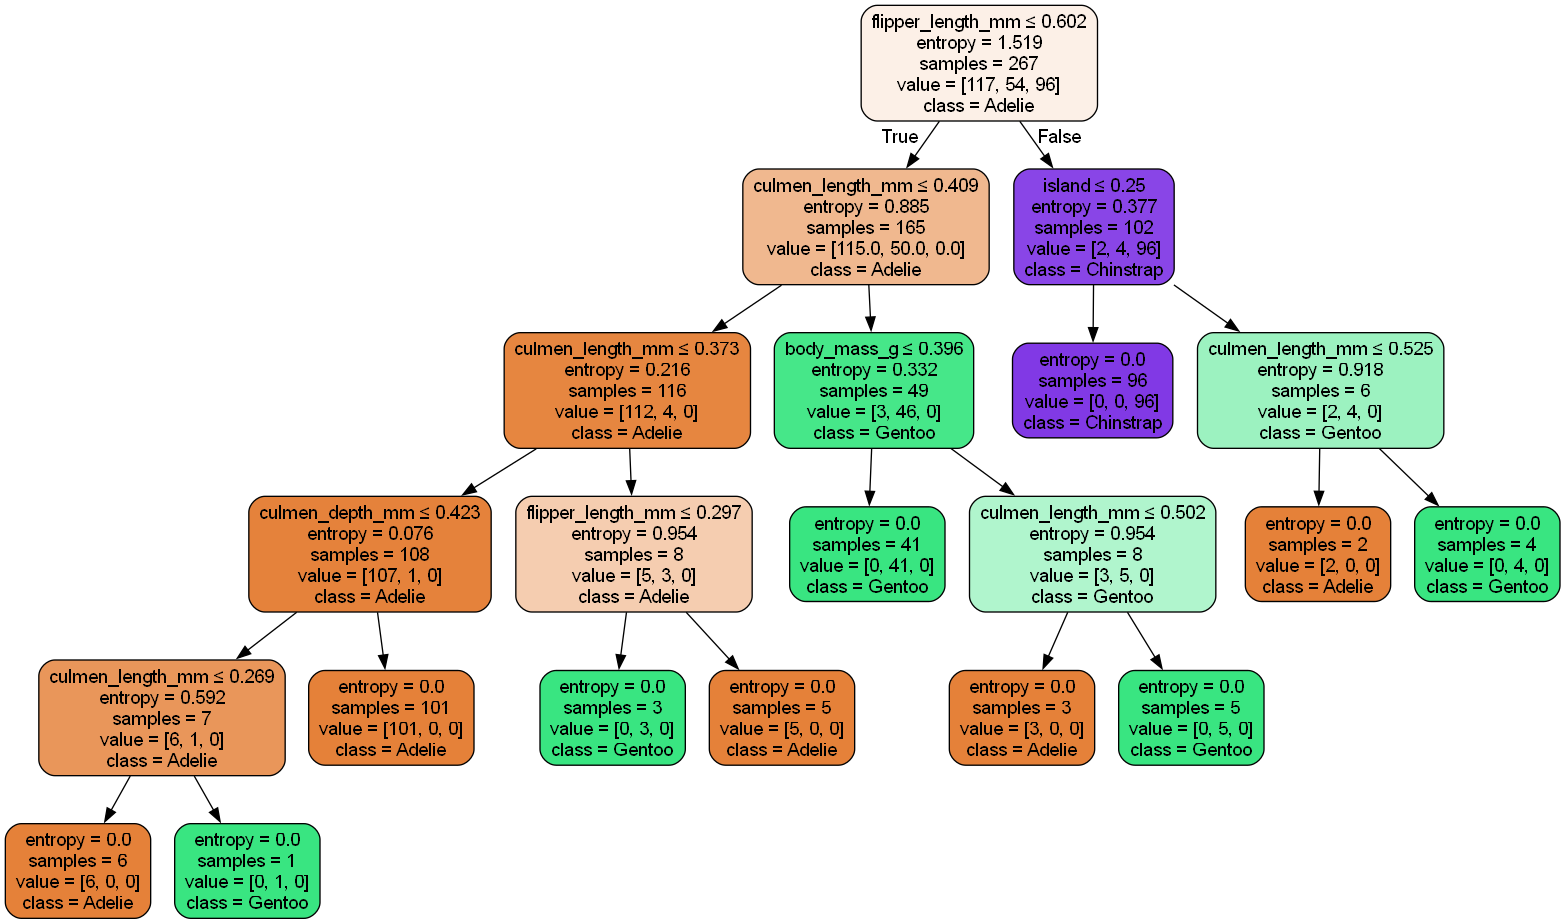

Saved decision tree as tree_depth_6_train_80.png


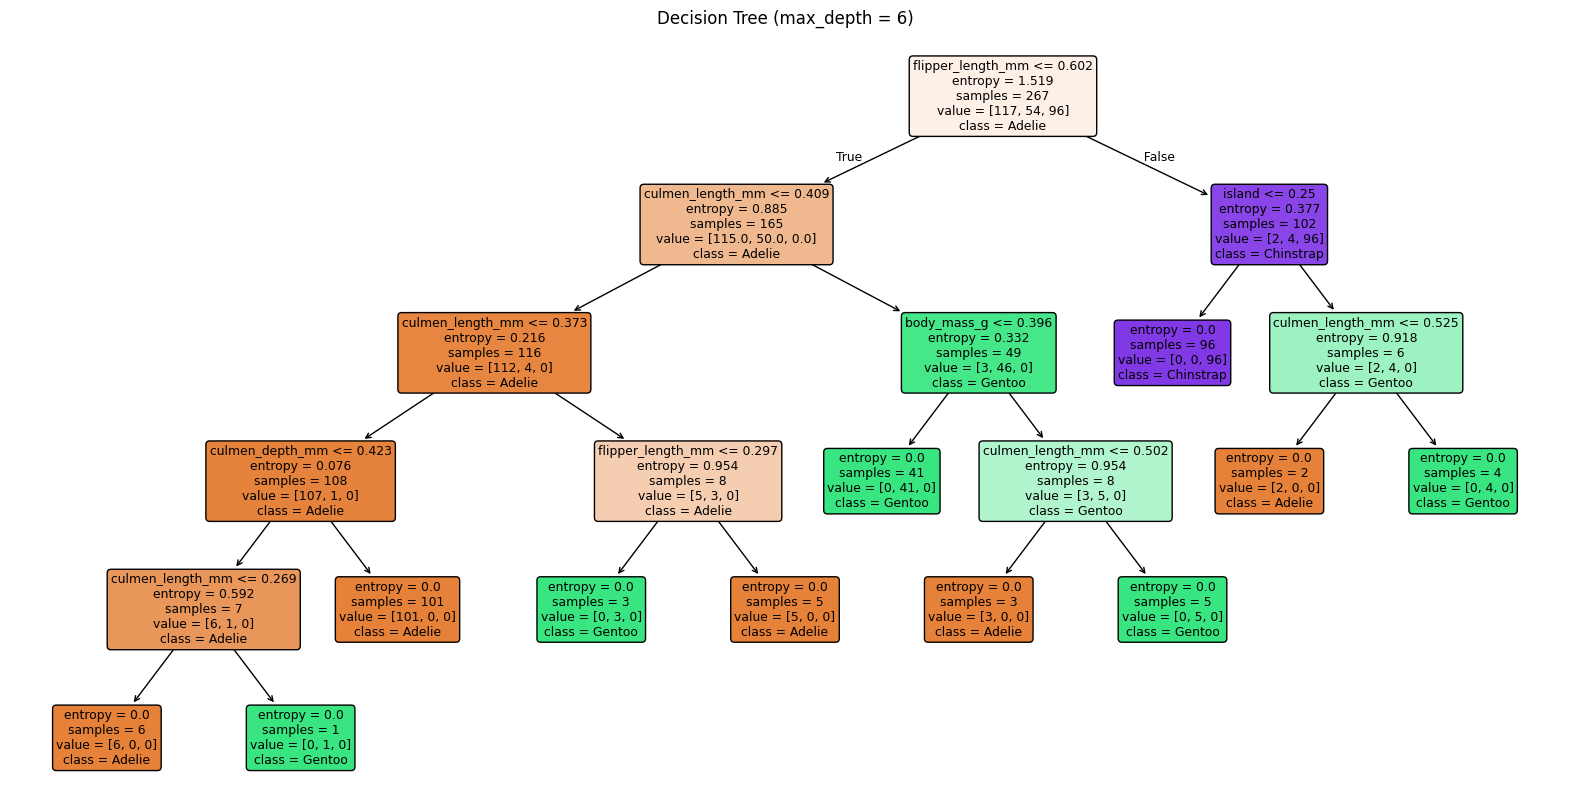


Classification Report for max_depth=6:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.88      1.00      0.93        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



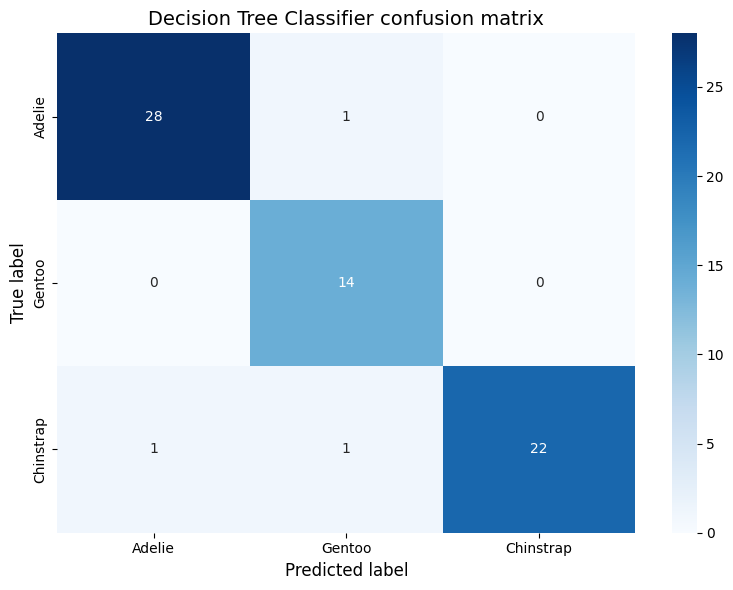

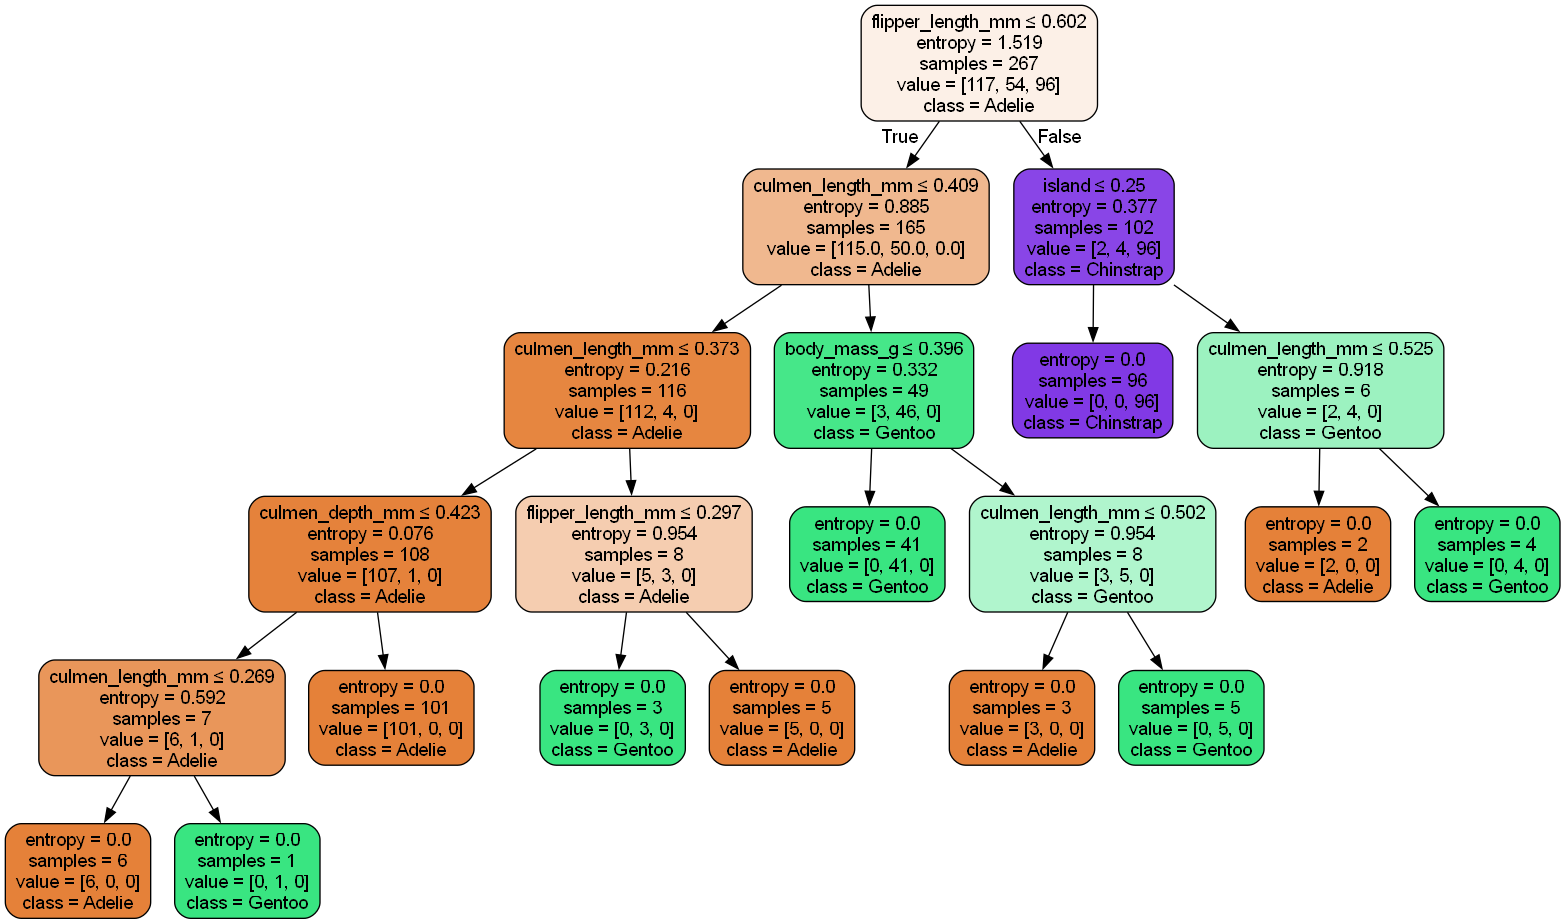

Saved decision tree as tree_depth_7_train_80.png


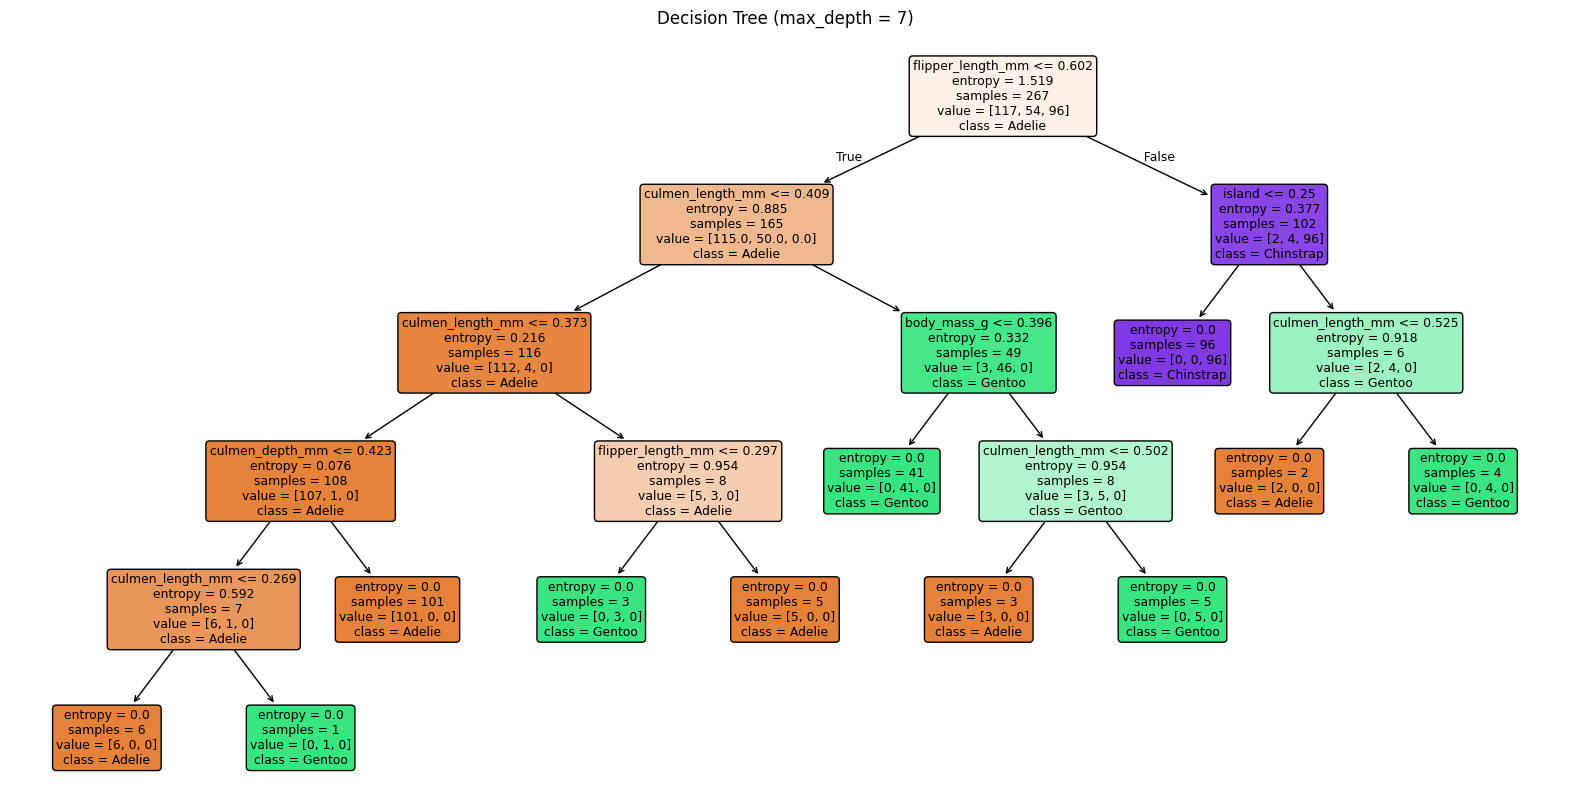


Classification Report for max_depth=7:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
      Gentoo       0.88      1.00      0.93        14
   Chinstrap       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



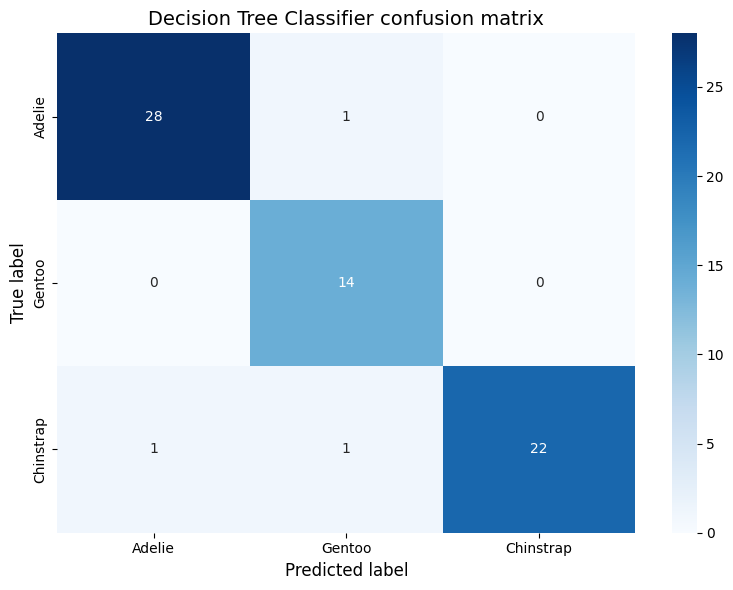


Accuracy for Different Decision Tree Depths:
max_depth  accuracy
Unlimited  0.955224
        2  0.940299
        3  0.940299
        4  0.940299
        5  0.955224
        6  0.955224
        7  0.955224


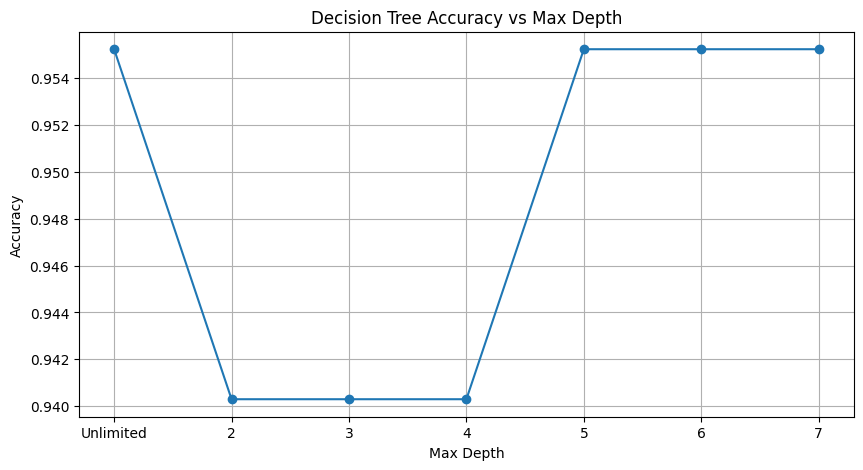

In [13]:

max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_accuracy_results = evaluate_decision_tree_depths(X, y, max_depths)
